In [190]:
import pandas as pd
import bamboolib as bam
import plotly.express as px
import numpy as np
from datetime import datetime
import re
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn
bam.enable()
url1 = "https://dshs.texas.gov/coronavirus/TexasCOVID19DailyCountyCaseCountData.xlsx"
url2 = "https://dshs.texas.gov/coronavirus/TexasCOVID-19CumulativeTestsOverTimebyCounty.xlsx"
path1 = "./Rt_no_Rolling.csv"
def getExcel(url, sheet, head):
    df = pd.read_excel(url,sheet_name=sheet, header=head)
    df=df.truncate(before=0,after=253)
    return df

df = getExcel(url1, 'Cases by County', 2)
df.keys()
df2 = df.set_index('County Name')

dftesting  = getExcel(url2, 'Total Tests Received', 1)
dftesting.keys()
dft2 = dftesting.set_index('County')

dfrate = pd.read_csv(path1)
dfr2 = dfrate.truncate(47, 191)

dfr2=dfr2.rename(columns={'Unnamed: 0': 'Dates'})
dfr2=dfr2.set_index('Dates')

dfr2=dfr2.T.copy()
dates = [datetime.strptime(sub, '%Y/%m/%d') for sub in dfr2.keys()]
dfr2=dfr2.T.copy()
dfr2.index = dates
dfr2.T.mean()

Success: the bamboolib extension was enabled successfully. You can disable it via 'bam.disable()'. You will now see a magic bamboolib button when you display your dataframes, for example via 'df'


2020-04-21    2.148312
2020-04-22    2.286394
2020-04-23    2.259013
2020-04-24    2.389237
2020-04-25    2.527050
                ...   
2020-09-08    1.895782
2020-09-09    1.891332
2020-09-10    1.711340
2020-09-11    1.561637
2020-09-12    1.937014
Length: 145, dtype: float64

In [191]:
url3 = 'https://www.indexmundi.com/facts/united-states/quick-facts/texas/population#table'
population = pd.read_html(url3)
pop = population[0]
pop = pop.loc[~(pop['County'].isin(['King', 'Borden', 'Loving']))]
pop

,County,Value
0,Anderson,58057
1,Andrews,18128
2,Angelina,87092
3,Aransas,23792
4,Archer,8786
...,...,...
249,Wood,45129
250,Yoakum,8591
251,Young,18045
252,Zapata,14190


In [192]:
#data prep
dft3 = dft2.T.copy()
dft3 = dft3.reset_index()
dft3 = dft3.replace('--', np.nan)
dft3 = dft3.replace('-', np.nan)
dft3 = dft3.fillna(method='ffill')
dft3.columns = [str(column) for column in dft3.columns]
dft3 = dft3.drop(columns=['Borden', 'King', 'Loving'])
dft3.index = dft3['index']
dft3 = dft3.drop(columns='index')
dft3 = dft3.T.copy()
pattern = re.compile('[a-z]+\s[0-9]+', re.IGNORECASE)
#get dates
dates2 = [datetime.strptime(pattern.findall(sub)[0], '%B %d') for sub in dft3.keys()]
dates2
dft3 = dft3.T.copy()
dft3.index = dates2

#get early testing data
dft3e = dft3.truncate('1900-04-21', '1900-06-30')
dft3em = dft3e.mean().to_frame()
dft3em.index.name = 'County'
dft3em = pd.merge(pop, dft3em, on='County')
dft3em.columns = ['County', 'Population', 'Mean_Tests']
dft3em['Per_100k'] = (dft3em['Mean_Tests'] / dft3em['Population']) * 100000
dft3em

,County,Population,Mean_Tests,Per_100k
0,Anderson,58057,1783.239437,3071.532178
1,Andrews,18128,41.014085,226.247156
2,Angelina,87092,2015.140845,2313.807060
3,Aransas,23792,193.633803,813.860974
4,Archer,8786,50.253521,571.972697
...,...,...,...,...
246,Wood,45129,430.647887,954.259761
247,Yoakum,8591,101.521127,1181.714897
248,Young,18045,492.887324,2731.434325
249,Zapata,14190,203.352113,1433.066333


In [193]:
#get a threshold
mean_of_all = dft3em['Per_100k'].T.copy().mean()
print(mean_of_all)

1859.6242264951686


In [194]:

#get the mean of each counties testing
dft3eg = []
#if a counties mean testing is greater than the average mean append
for i in dft3em.itertuples(): 
    if float(i[4]) > mean_of_all:
        dft3eg.append(i)

#put the list into a dataframe
dft4eg = pd.DataFrame(dft3eg)

#get a list of all counties with above average testing
dft3e = dft3e[dft4eg['County']]
#dfearly = dft3e
dft3e

County,Anderson,Angelina,Armstrong,Austin,Bee,Bell,Bexar,Blanco,Bosque,Bowie,...,Titus,Travis,Victoria,Walker,Washington,Wharton,Wichita,Willacy,Williamson,Young
1900-04-21,270.0,282.0,4.0,183.0,142.0,837.0,10274.0,144.0,79.0,910.0,...,33.0,10258.0,862.0,673.0,105.0,267.0,1801.0,161.0,3438.0,311.0
1900-04-22,282.0,311.0,5.0,185.0,153.0,908.0,10804.0,147.0,80.0,999.0,...,39.0,10563.0,898.0,743.0,111.0,280.0,1904.0,164.0,3566.0,322.0
1900-04-23,297.0,431.0,8.0,96.0,52.0,957.0,11020.0,284.0,21.0,981.0,...,21.0,10138.0,1215.0,404.0,83.0,120.0,1533.0,213.0,3093.0,96.0
1900-04-24,329.0,434.0,8.0,234.0,108.0,1043.0,9231.0,337.0,102.0,1133.0,...,34.0,10927.0,1104.0,637.0,122.0,295.0,1724.0,231.0,3231.0,269.0
1900-04-25,337.0,469.0,8.0,253.0,110.0,1107.0,9316.0,366.0,106.0,1218.0,...,38.0,11775.0,1167.0,662.0,147.0,325.0,1820.0,242.0,3438.0,279.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1900-06-26,6548.0,3872.0,180.0,1511.0,2473.0,23421.0,68876.0,2251.0,1034.0,7114.0,...,2964.0,62335.0,3903.0,13509.0,2540.0,2399.0,7047.0,1701.0,20608.0,748.0
1900-06-27,6563.0,4000.0,180.0,1582.0,2482.0,23489.0,70510.0,2319.0,1040.0,7333.0,...,2970.0,63825.0,3944.0,13633.0,2556.0,2506.0,7115.0,1798.0,21101.0,749.0
1900-06-28,6571.0,4063.0,181.0,1601.0,2512.0,23669.0,73533.0,2337.0,1055.0,7803.0,...,2982.0,64756.0,4066.0,13757.0,2567.0,2617.0,7127.0,1842.0,21312.0,751.0
1900-06-29,6578.0,4122.0,184.0,1621.0,2528.0,23832.0,76562.0,2365.0,1059.0,7831.0,...,2987.0,66745.0,4206.0,13826.0,2579.0,2636.0,7198.0,1936.0,21667.0,754.0


In [195]:
dfr2 = dfr2.fillna(0.0)
dfre = dfr2.truncate('2020-07-01', '2020-09-09')
dfre = dfre.reset_index()
dfre

,index,Anderson,Andrews,Angelina,Aransas,Archer,Armstrong,Atascosa,Austin,Bailey,...,Willacy,Williamson,Wilson,Winkler,Wise,Wood,Yoakum,Young,Zapata,Zavala
0,2020-07-01,2.645781,1.163854,1.013150,1.490662,1.019603,4.954606,1.897683,1.184034,0.911764,...,1.768367,1.030384,2.214843,1.262299,1.544588,1.707694,2.019239,2.174833,1.189885,1.130291
1,2020-07-02,2.290951,0.926648,1.026659,1.310078,1.032529,4.985389,1.676411,0.889900,0.831145,...,1.816185,0.886956,1.952372,1.124305,1.581389,1.596854,1.909006,2.049486,1.034556,1.156370
2,2020-07-03,1.730377,0.891797,1.026416,1.478520,1.029700,4.995478,1.530534,1.427799,0.786353,...,1.422522,0.640292,1.678523,0.941834,1.488334,1.386229,1.769690,1.691432,1.135753,1.188719
3,2020-07-04,1.635556,0.832551,1.767313,1.264151,1.431913,4.998643,1.242476,1.740767,1.221993,...,1.288399,1.508523,1.408022,1.132026,1.311818,1.724982,1.353999,1.174929,1.275982,1.536821
4,2020-07-05,2.070569,1.153290,1.352635,1.259657,1.933382,4.999603,1.145664,1.937640,0.891206,...,1.124487,1.378361,1.188755,1.002780,1.296091,1.480613,1.226059,1.308988,0.968253,1.512071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,2020-09-05,3.177342,1.021463,0.038184,1.568059,0.741262,4.121909,0.613292,1.039735,0.878142,...,1.535702,0.476266,1.154687,0.630973,0.318868,0.676193,1.197334,0.593863,0.555830,1.053035
67,2020-09-06,3.861652,0.655903,1.760863,1.167205,1.010433,4.632147,1.379256,1.008049,1.154439,...,1.205433,0.851558,1.835815,1.349446,0.464588,0.978420,0.789022,0.918924,1.504519,2.009379
68,2020-09-07,3.813838,0.771418,2.461149,1.052067,0.835263,4.864684,2.226263,1.323308,1.395559,...,1.001839,0.923694,3.115081,1.646460,0.759696,1.781072,0.424266,1.097313,1.648694,2.059824
69,2020-09-08,2.458415,0.676085,5.556528,0.082536,0.980844,9.908210,3.133568,0.903057,0.773499,...,0.127312,0.988381,3.081494,1.377600,0.858090,1.693617,0.813481,1.187160,1.695661,2.151479


In [211]:
dfreg = dfre[dft4eg['County']]
dfreg

,Anderson,Angelina,Armstrong,Austin,Bee,Bell,Bexar,Blanco,Bosque,Bowie,...,Titus,Travis,Victoria,Walker,Washington,Wharton,Wichita,Willacy,Williamson,Young
0,2.645781,1.013150,4.954606,1.184034,1.700883,1.197562,1.444268,0.997413,2.211677,1.263417,...,1.396450,1.558719,2.320071,1.541742,0.969767,0.720040,1.234971,1.768367,1.030384,2.174833
1,2.290951,1.026659,4.985389,0.889900,2.404838,1.119521,1.201083,1.359989,1.789240,1.489865,...,1.352650,1.185271,1.916487,1.331316,0.918342,0.618744,1.035059,1.816185,0.886956,2.049486
2,1.730377,1.026416,4.995478,1.427799,3.119598,1.060656,1.053558,1.233004,1.270236,1.138180,...,0.940137,1.040005,1.597709,1.167015,1.398932,0.688112,1.025423,1.422522,0.640292,1.691432
3,1.635556,1.767313,4.998643,1.740767,3.080649,1.140532,0.929062,1.149478,1.113559,1.110209,...,2.703395,0.880711,1.752599,1.002366,1.347859,0.792290,1.016491,1.288399,1.508523,1.174929
4,2.070569,1.352635,4.999603,1.937640,2.754033,1.071745,0.795094,4.930889,3.478677,0.862404,...,2.481226,0.833023,1.282240,1.072930,1.854757,0.902226,1.031275,1.124487,1.378361,1.308988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,3.177342,0.038184,4.121909,1.039735,0.955732,0.576067,0.922517,0.887523,0.787641,1.666961,...,0.663618,0.982659,0.877745,1.534879,1.053637,1.105268,0.677704,1.535702,0.476266,0.593863
67,3.861652,1.760863,4.632147,1.008049,0.928254,0.654462,0.921494,0.675261,0.659487,1.405107,...,0.578292,1.105248,1.200908,1.259736,0.674405,1.143323,0.829809,1.205433,0.851558,0.918924
68,3.813838,2.461149,4.864684,1.323308,0.824426,0.589228,0.848894,0.803461,0.553604,1.243957,...,0.721073,1.059054,1.244170,1.122044,1.213359,1.171945,0.805535,1.001839,0.923694,1.097313
69,2.458415,5.556528,9.908210,0.903057,0.117223,0.550673,0.762246,0.579911,0.465930,1.013752,...,0.825373,1.266122,1.442313,1.071475,1.256246,1.166942,0.981420,0.127312,0.988381,1.187160


In [212]:
X = dfreg.T.mean()
Y = dfearly.T.mean()
data3 = pd.concat([X,Y], axis=1)
data3.columns = ['Infection_Rate', 'Mean_Tests']
data3
#data3.index = keys2
#data3

,Infection_Rate,Mean_Tests
0,1.786991,3099.914894
1,1.533867,3259.595745
2,1.378665,3316.000000
3,1.478517,3768.255319
4,1.738421,4056.936170
...,...,...
66,1.004939,27518.148936
67,1.317233,28475.531915
68,1.565031,29489.893617
69,1.751258,30170.382979


In [213]:
model1 = smf.ols('Mean_Tests~Infection_Rate',data = data3)
results1 = model1.fit()
results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Mean_Tests   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     6.551
Date:                Mon, 28 Sep 2020   Prob (F-statistic):             0.0127
Time:                        21:30:52   Log-Likelihood:                -736.46
No. Observations:                  71   AIC:                             1477.
Df Residuals:                      69   BIC:                             1481.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       2.892e+04   5640.974      5.128      0.000    1.77e+04    4.02e+04
Infection_Rate -1.085e+04   4240.722     -2.559      0.013   -1.93e+04   -2394.046
==============================================================================
Omnibus:                        6.829   Durbin-Watson:                   0.029
Prob(Omnibus):                  0.033   Jarque-Bera (JB):                7.008
Skew:                           0.765   Prob(JB):                       0.0301
Kurtosis:                       2.834   Cond. No.                         12.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

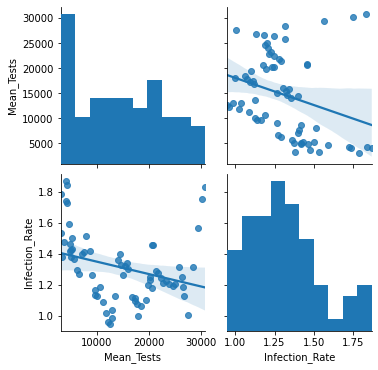

In [214]:
seaborn.pairplot(data3, vars=['Mean_Tests', 'Infection_Rate'], kind='reg')

In [215]:
X=list(dfr2['Williamson'])
Y=list(dft3['Williamson'])
X = sm.add_constant(X)
model = sm.OLS(Y, X)
results = model.fit()
print(results.t_test([1, 0]))
results.summary()

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0           4.72e+04   4581.744     10.302      0.000    3.81e+04    5.63e+04


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     16.93
Date:                Mon, 28 Sep 2020   Prob (F-statistic):           6.52e-05
Time:                        21:32:11   Log-Likelihood:                -1651.1
No. Observations:                 145   AIC:                             3306.
Df Residuals:                     143   BIC:                             3312.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        4.72e+04   4581.744     10.302      0.000    3.81e+04    5.63e+04
x1         -1.549e+04   3765.948     -4.114      0.000   -2.29e+04   -8050.717
==============================================================================
Omnibus:                       14.049   Durbin-Watson:                   0.032
Prob(Omnibus):                  0.001   Jarque-Bera (JB):                7.850
Skew:                           0.397   Prob(JB):                       0.0197
Kurtosis:                       2.182   Cond. No.                         5.04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""